In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import tqdm
import copy
tqdm.tqdm.pandas()

# Time taken for run

In [38]:
import datetime
os.chdir('/home/upamanyu/GWANN/Code_AD/Runs')
runs = [f for f in os.listdir('.') if f.endswith('.txt')]
total_time = datetime.timedelta(0)
for run in runs:
    with open(run) as f:
        time = f.readlines()[-1].strip()
        try:
            time = datetime.timedelta(
                            hours=int(time.split(':')[0]), 
                            minutes=int(time.split(':')[1]), 
                            seconds=int(time.split(':')[2].split('.')[0]), 
                            milliseconds=int(time.split(':')[2].split('.')[1]))
            total_time += time
        except ValueError:
            print(f'{run} does not end with a time.')

print((total_time/2).total_seconds()/3600)

cov142.txt does not end with a time.
55.392441805555556


# Stability of null dist

## Upset Plots

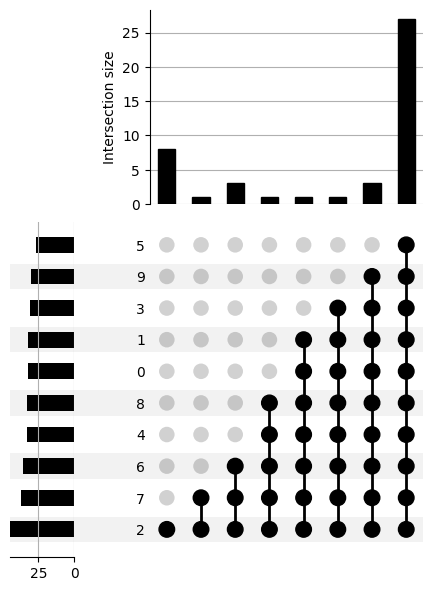

In [14]:
from upsetplot import UpSet, from_contents
hit_dict = {}
for dw in range(0, 10):
    df = pd.read_csv(f"/home/upamanyu/GWANN/Code_AD/results_Sens8_v4/hits_nsuperwins_1_{dw}.csv")
    glist = df['subgene'].apply(lambda x: x.split('_')[0]).unique()
    hit_dict[str(dw)] = list(glist)

data = from_contents(hit_dict)
# data = from_memberships(hit_dict)
# data
upset = UpSet(data)
upset.plot()
plt.show()

## Histogram of lost and gained hits

18
18
27
16
18
13
19
22
18
16


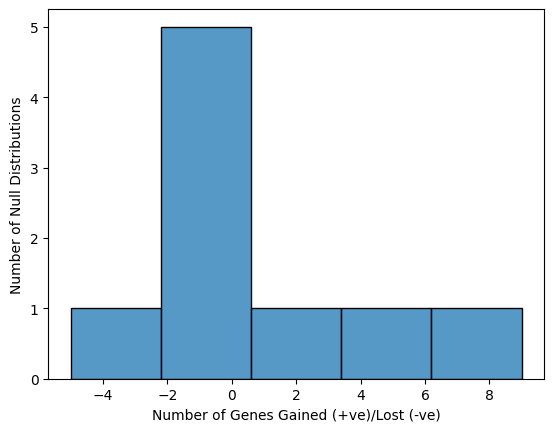

In [9]:
os.chdir('/home/upamanyu/GWANN/Code_AD/results_Sens8_v4/LD')
hit_dict = {}
hit_gain_loss = []
for dw in range(0, 10):
    df = pd.read_csv(f"Sens8_v4_{dw}_r20.8_pruned_gene_hits.csv")
    glist = df.loc[~df['pruned']]['subgene'].unique()
    print(len(glist))
    hit_dict[str(dw)] = list(glist)
    if dw > 0:
        hit_gain_loss.append(len(set(hit_dict[str(dw)])) - len(set(hit_dict['0'])))
    
x_lim = np.max(np.abs(hit_gain_loss))
sns.histplot(hit_gain_loss)
ax = plt.gca()
ax.set_xlabel('Number of Genes Gained (+ve)/Lost (-ve)')
ax.set_ylabel('Number of Null Distributions')
# ax.set_xticks(range(-x_lim, x_lim+1, 2))
# ax.set_xticklabels(range(-x_lim, x_lim+1, 2))
plt.show()

# Traditional GWAS

## Extract (SNPs)

In [ ]:
import sys
sys.path.append('../../')
from GWANN.dataset_utils import get_win_snps

gdf = pd.read_csv('../../GWANN/datatables/gene_annot.csv')
gdf.set_index('symbol', inplace=True)

os.chdir('/home/upamanyu/GWANN/Code_AD/results_Sens8_v4')
summ_df = pd.read_csv('summary_nsuperwins_1_gene_level.csv')
summ_df['Gene'] = summ_df['Gene'].apply(lambda x: x.split('_')[0])
summ_df['start'] = gdf.loc[summ_df['Gene'], 'start'].values - 2500
summ_df['end'] = gdf.loc[summ_df['Gene'], 'end'].values + 2500

snps = []
for _, row in tqdm.tqdm(summ_df.iterrows(), total=summ_df.shape[0]):
    win = -1
    start = row['start']
    end = row['end']
    chrom = row['Chrom']
    win_snps = get_win_snps(chrom=str(chrom), start=start, end=end, win=win, 
                        pgen_data=f'/mnt/sdh/upamanyu/GWANN/GWANN_pgen/UKB_chr{chrom}.pvar')
    snps.extend(win_snps['ID'].to_list())

## Phenotype and Keep

In [40]:
os.chdir('/home/upamanyu/GWANN/Code_AD/params/reviewer_rerun_Sens8')
pheno_df = pd.read_csv('all_ids_FH_AD.csv')
pheno_df['FID'] = pheno_df['iid'].values
pheno_df.rename(columns={'iid': 'IID'}, inplace=True)
pheno_df['FH_AD'] = pheno_df['FH_AD'].astype(int)
pheno_df.loc[pheno_df['FH_AD']==1, 'FH_AD'] = 2
pheno_df.loc[pheno_df['FH_AD']==0, 'FH_AD'] = 1

os.chdir('/mnt/sdh/upamanyu/GWANN/GWAS')
pheno_df[['FID', 'IID', 'FH_AD']].to_csv('pheno.txt', sep='\t', index=False)
pheno_df[['FID', 'IID']].to_csv('keep.txt', sep='\t', index=False)
# pheno_df[['IID']].to_csv('keep.txt', sep='\t', index=False, header=False)

## Covariates

In [44]:
os.chdir('/mnt/sdh/upamanyu/GWANN/GWAS')
keep = pd.read_csv('keep.txt', sep='\t')['IID'].to_list()
cov_df = pd.read_csv('../Variables_UKB.txt', sep=' ', comment='#')
cov_df = cov_df[cov_df['ID_1'].isin(keep)]
assert len(keep) == cov_df.shape[0]
cov_df['FID'] = cov_df['ID_1'].values
cov_df.rename(columns={'ID_1': 'IID'}, inplace=True)
cov_df.filter(['FID', 'IID', 'f.31.0.0', 'f.21003.0.0', 'f.6138_ISCED', 
                'f.22009.0.1', 'f.22009.0.2', 'f.22009.0.3', 'f.22009.0.4', 
                'f.22009.0.5', 'f.22009.0.6']).to_csv('covariates.txt', sep='\t', index=False)


## Process summary stats

In [137]:
from intervaltree import IntervalTree
gdf = pd.read_csv('/home/upamanyu/GWANN/GWANN/datatables/gene_annot.csv')
gtrees = {c:IntervalTree() for c in range(1, 23)}
for c, idxs in gdf.groupby('chrom').groups.items():
    sub_df = gdf.loc[idxs].copy()
    for _, row in sub_df.iterrows():
        gtrees[c][row['start']-2501:row['end']+2501] = row['symbol']

In [ ]:
os.chdir('/mnt/sdh/upamanyu/GWANN/GWAS')
summary_stats = pd.read_csv('FH_AD_summary_stats.txt', sep='\t')
summary_stats = summary_stats.loc[summary_stats['TEST'] == 'ADD']
summary_stats.head()

In [155]:
def get_gene_symbol(chrom, pos):
    try:
        return [g.data for g in list(gtrees[chrom][pos])]
    except:
        print(chrom, pos)
        return None
stats = summary_stats.copy()
stats['symbol'] = stats.progress_apply(lambda r: get_gene_symbol(r['#CHROM'], r['POS']), axis=1).values
stats = stats.explode('symbol')
gene_stats = stats.groupby('symbol').progress_apply(lambda x: x.nsmallest(1, 'P')).reset_index(drop=True)

100%|██████████| 2950159/2950159 [01:02<00:00, 47133.99it/s]


In [ ]:
top_100 = gene_stats.sort_values('P').head(100)
hits = gene_stats.loc[gene_stats['P'] < 5e-8].copy()
hits[['#CHROM', 'ID', 'symbol', 'P', 'Z_STAT']].sort_values('Z_STAT', ascending=False).head()

In [168]:
os.chdir('/home/upamanyu/GWANN/Code_AD/results_Sens8_v4/trad_GWAS')
gene_stats.rename(columns={'#CHROM':'Chrom'}).to_csv('trad_GWAS_summary.csv', index=False)
top_100.rename(columns={'#CHROM':'Chrom'}).to_csv('trad_GWAS_top_100.csv', index=False)
hits.rename(columns={'#CHROM':'Chrom'}).to_csv('trad_GWAS_hits.csv', index=False)

# GWANN vs TradGWAS vs EADB GWAS

## Overlap of hits

In [2]:
os.chdir('/home/upamanyu/GWANN/Code_AD/results_Sens8_v4')
gwann = pd.read_csv('LD/r20.8_pruned_gene_hits_1e-25.csv')
gwann = gwann.loc[~gwann['pruned']]
gwann.sort_values('p_stat_trial_A', inplace=True)
gwann['ld_block'] = gwann['ld_block'].apply(lambda x: set(eval(x)))
gwann.rename(columns={'Gene':'Hit_Gene', 'ld_block':'Gene'}, inplace=True)

trad = pd.read_csv('trad_GWAS/LD/r20.8_pruned_gene_hits_5e-08.csv')
trad = trad.loc[~trad['pruned']]
trad.rename(columns={'symbol':'Gene'}, inplace=True)
trad.sort_values('P', inplace=True)
trad['ld_block'] = trad['ld_block'].apply(lambda x: set(eval(x)))
trad.rename(columns={'Gene':'Hit_Gene', 'ld_block':'Gene'}, inplace=True)

eadb = pd.read_csv('EADB_GWAS_hits.tsv', sep='\t')
eadb = eadb.filter(['CHR_ID', 'CHR_POS', 'REPORTED GENE(S)', 'MAPPED_GENE', 'P-VALUE'])
eadb['MAPPED_GENE'] = eadb['MAPPED_GENE'].apply(lambda x: x.split(' - ') if type(x) == str else x)
eadb['MAPPED_GENE'] = eadb['MAPPED_GENE'].apply(lambda x: x.split(',') if type(x) == str else x)
eadb.loc[eadb.shape[0]] = [19, -1, 'APOE', ['APOE'], 0]
eadb['MAPPED_GENE'] = eadb['MAPPED_GENE'].apply(lambda x: set(x))
eadb = eadb.rename(columns={'MAPPED_GENE':'Gene'})

In [3]:
xs = {'GWANN\n(n=84,220)':gwann, 'TradGWAS\n(n=84,220)':trad, 'EADB GWAS\n(n=788,989)':eadb}
hit_overlap_mat = np.zeros((3, 3))
for i, x1 in enumerate(xs.keys()):
    for j, x2 in enumerate(xs.keys()):
        g1 = xs[x1]['Gene'].values
        g2 = xs[x2]['Gene'].values
        g_small = g1 if len(g1) < len(g2) else g2
        g_large = g2 if len(g1) < len(g2) else g1
        g1 = g_small
        g2 = g_large
        og = []
        for g in g1:
            o = [list(g.intersection(g_)) for g_ in g2]
            isec = [item for sublist in o for item in sublist]
            og.append(isec)
        og = [ogi for ogi in og if len(ogi) != 0]
        og_ = []
        for ogi in og:
            if ogi not in og_:
                og_.append(ogi)
            else:
                print(ogi)
        og = og_
        hit_overlap_mat[i, j] = len(og)
        # og = set([item for sublist in og for item in sublist])
        if i<=j:
            print(len(g1), len(g2), len(og), x1, x2, og)
            print()
hit_overlap_df = pd.DataFrame(np.tril(hit_overlap_mat), index=[x.split('\n')[0] for x in xs.keys()], columns=xs.keys())
hit_overlap_df[hit_overlap_df == 0] = np.nan
hit_overlap_df

18 18 18 GWANN
(n=84,220) GWANN
(n=84,220) [['EXOC3L2', 'BCAM', 'APOE', 'APOC1', 'APOC1P1', 'RELB', 'TOMM40'], ['BIN1'], ['NRG3'], ['LRRC7'], ['ROR1'], ['RPS6KC1'], ['APH1B'], ['AKR1C6P'], ['SORL1'], ['SRGAP2B'], ['HSP90AB4P'], ['LINGO2'], ['PALD1'], ['PCDH9'], ['ADAM10'], ['SPI1'], ['SMYD3'], ['SYNPO']]

2 18 2 GWANN
(n=84,220) TradGWAS
(n=84,220) [['TOMM40', 'EXOC3L2', 'BCAM', 'APOE', 'APOC1', 'APOC1P1'], ['SORL1']]

18 90 5 GWANN
(n=84,220) EADB GWAS
(n=788,989) [['APOE'], ['BIN1'], ['APH1B'], ['SORL1', 'SORL1'], ['SPI1']]

2 2 2 TradGWAS
(n=84,220) TradGWAS
(n=84,220) [['EXOC3L2', 'BCAM', 'BLOC1S3', 'APOE', 'APOC1', 'APOC1P1', 'TOMM40'], ['SORL1']]

2 90 2 TradGWAS
(n=84,220) EADB GWAS
(n=788,989) [['APOE'], ['SORL1', 'SORL1']]

['PLCG2', 'PLCG2']
['MME', 'MME']
['TREM2', 'TREM2', 'TREM2']
['SORL1', 'SORL1']
['SLC24A4', 'SLC24A4']
90 90 85 EADB GWAS
(n=788,989) EADB GWAS
(n=788,989) [['SLC24A4', 'SLC24A4'], ['IGHG1', 'IGHG3'], ['IGHV3-64', 'IGHV3-65'], ['SPPL2A', 'RN7SL354P'], ['MI

,"GWANN\n(n=84,220)","TradGWAS\n(n=84,220)","EADB GWAS\n(n=788,989)"
GWANN,18.0,NaN,NaN
TradGWAS,2.0,2.0,NaN
EADB GWAS,5.0,2.0,85.0


## Overlap of top 100

In [10]:
###########################################################
# Use if top100 selection should be done after LD pruning #
###########################################################

os.chdir('/home/upamanyu/GWANN/Code_AD/results_Sens8_v4')
gwann = pd.read_csv('LD/r20.8_pruned_gene_hits_5e-09.csv')
gwann = gwann.loc[~gwann['pruned']]
gwann.sort_values('p_stat_trial_A', inplace=True)
gwann = gwann.iloc[:100]

# Overlap with LD block
# gwann['ld_block'] = gwann['ld_block'].apply(lambda x: set(eval(x)))
# gwann.rename(columns={'Gene':'Hit_Gene', 'ld_block':'Gene'}, inplace=True)

# Overlap with hit gene in LD block
gwann['Gene'] = gwann['Gene'].apply(lambda x: set([x]))

trad = pd.read_csv('trad_GWAS/LD/r20.8_pruned_gene_hits_1e-04.csv')
trad = trad.loc[~trad['pruned']]
trad.rename(columns={'symbol':'Gene'}, inplace=True)
trad.sort_values('P', inplace=True)
trad = trad.iloc[:100]

# Overlap with LD block
# trad['ld_block'] = trad['ld_block'].apply(lambda x: set(eval(x)))
# trad.rename(columns={'Gene':'Hit_Gene', 'ld_block':'Gene'}, inplace=True)

# Overlap with hit gene in LD block
trad['Gene'] = trad['Gene'].apply(lambda x: set([x]))

eadb = pd.read_csv('EADB_GWAS_hits.tsv', sep='\t')
eadb = eadb.filter(['CHR_ID', 'CHR_POS', 'REPORTED GENE(S)', 'MAPPED_GENE', 'P-VALUE'])
eadb['MAPPED_GENE'] = eadb['MAPPED_GENE'].apply(lambda x: x.split(' - ') if type(x) == str else x)
eadb['MAPPED_GENE'] = eadb['MAPPED_GENE'].apply(lambda x: x.split(',') if type(x) == str else x)
eadb.loc[eadb.shape[0]] = [19, -1, 'APOE', ['APOE'], 0]
eadb['MAPPED_GENE'] = eadb['MAPPED_GENE'].apply(lambda x: set(x))
eadb = eadb.rename(columns={'MAPPED_GENE':'Gene'})

############################################################
# Use if top100 selection should be done before LD pruning #
############################################################
# os.chdir('/home/upamanyu/GWANN/Code_AD/results_Sens8_v4')
# gwann = pd.read_csv('summary_nsuperwins_1_gene_level.csv')
# gwann.sort_values('p_stat_trial_A', inplace=True)
# gwann = gwann.iloc[:100]
# gwann['Gene'] = gwann['Gene'].apply(lambda x: set([x]))

# trad = pd.read_csv('trad_GWAS/trad_GWAS_top_100.csv')
# trad.rename(columns={'symbol':'Gene'}, inplace=True)
# trad.sort_values('P', inplace=True)
# trad = trad.iloc[:100]
# trad['Gene'] = trad['Gene'].apply(lambda x: set([x]))

# eadb = pd.read_csv('EADB_GWAS_hits.tsv', sep='\t')
# eadb = eadb.filter(['CHR_ID', 'CHR_POS', 'REPORTED GENE(S)', 'MAPPED_GENE', 'P-VALUE'])
# eadb['MAPPED_GENE'] = eadb['MAPPED_GENE'].apply(lambda x: x.split(' - ') if type(x) == str else x)
# eadb['MAPPED_GENE'] = eadb['MAPPED_GENE'].apply(lambda x: x.split(',') if type(x) == str else x)
# eadb.loc[eadb.shape[0]] = [19, -1, 'APOE', ['APOE'], 0]
# eadb['MAPPED_GENE'] = eadb['MAPPED_GENE'].apply(lambda x: set(x))
# eadb = eadb.rename(columns={'MAPPED_GENE':'Gene'})

In [11]:
# Overlap between all combinations of GWANN, TradGWAS and EADB
xs = {'GWANN\n(n=84,220)':gwann, 'TradGWAS\n(n=84,220)':trad, 'EADB GWAS\n(n=788,989)':eadb}
overlap_mat = np.zeros((3, 3))
for i, x1 in enumerate(xs.keys()):
    for j, x2 in enumerate(xs.keys()):
        g1 = xs[x1]['Gene'].values
        g2 = xs[x2]['Gene'].values
        g_small = g1 if len(g1) < len(g2) else g2
        g_large = g2 if len(g1) < len(g2) else g1
        g1 = g_small
        g2 = g_large
        og = []
        for g in g1:
            o = [list(g.intersection(g_)) for g_ in g2]
            isec = [item for sublist in o for item in sublist]
            og.append(isec)
        og = [ogi for ogi in og if len(ogi) != 0]
        og_ = []
        for ogi in og:
            if ogi not in og_:
                og_.append(ogi)
        og = og_
        overlap_mat[i, j] = len(og)
        # og = set([item for sublist in og for item in sublist])
        if i<=j:
            print(len(g1), len(g2), len(og), x1, x2, og)
            print()

overlap_df = pd.DataFrame(np.tril(overlap_mat), index=[x.split('\n')[0] for x in xs.keys()], columns=xs.keys())
overlap_df[overlap_df == 0] = np.nan
overlap_df

100 100 100 GWANN
(n=84,220) GWANN
(n=84,220) [['APOE'], ['BIN1'], ['NRG3'], ['LRRC7'], ['ROR1'], ['RPS6KC1'], ['APH1B'], ['AKR1C6P'], ['SORL1'], ['SRGAP2B'], ['HSP90AB4P'], ['LINGO2'], ['PALD1'], ['PCDH9'], ['ADAM10'], ['SPI1'], ['SMYD3'], ['SYNPO'], ['PLCB4'], ['CCDC13'], ['HIP1R'], ['SLC35A3'], ['EPHA5'], ['ACOT12'], ['CTSH'], ['RECK'], ['SP140'], ['MAP2K1'], ['MAN1A1'], ['KATNAL2'], ['LOC392364'], ['LOC400940'], ['HMG20A'], ['PICALM'], ['TFCP2'], ['EPHA1'], ['HKDC1'], ['FHOD3'], ['R3HDM1'], ['HPSE2'], ['TRPV1'], ['ZMIZ1-AS1'], ['CASP14'], ['RCBTB1'], ['PEX14'], ['TRPM7'], ['OR2A7'], ['MPP5'], ['GABRB3'], ['HNRNPA1'], ['MIR2116'], ['DLGAP1'], ['GRHL2'], ['ABCA7'], ['DLC1'], ['EXD3'], ['C8orf34'], ['RBFOX1'], ['LOC374443'], ['LINC00535'], ['KCNJ3'], ['PDSS2'], ['KLF3'], ['INSM1'], ['KRT84'], ['MYT1L'], ['IL6R'], ['PLXDC1'], ['FAM135B'], ['CNTNAP4'], ['MIR604'], ['HMGXB3'], ['ITGBL1'], ['RELN'], ['TBCCD1'], ['RBFOX2'], ['AICDA'], ['DSE'], ['SPATA6L'], ['MIR548B'], ['TM4SF18'], ['LINC0

,"GWANN\n(n=84,220)","TradGWAS\n(n=84,220)","EADB GWAS\n(n=788,989)"
GWANN,100.0,NaN,NaN
TradGWAS,17.0,100.0,NaN
EADB GWAS,8.0,5.0,85.0


## Overlap plot

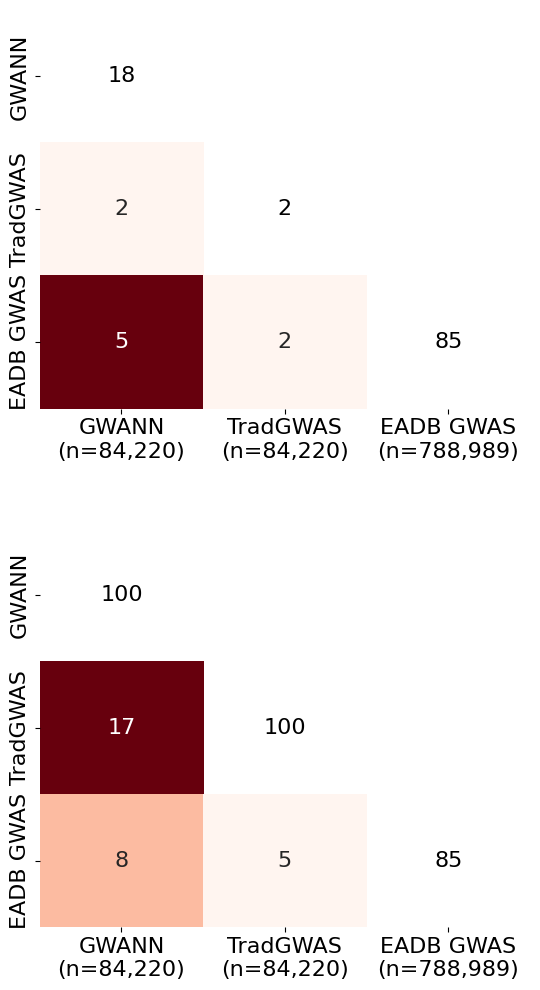

In [12]:
fig, axes = plt.subplots(2, 1,  figsize=(5.5, 10))
axes = axes.flatten()

for i, df in enumerate([hit_overlap_df, overlap_df]):
    plot_df = df.copy()
    for j in range(plot_df.shape[0]):
        plot_df.iloc[j, j] = np.nan
    sns.heatmap(plot_df, annot=True, cmap='Reds', ax=axes[i], cbar=False)
    # Add annotation for diagonal
    for j in range(plot_df.shape[0]):
        axes[i].text(j+0.5, j+0.5, int(df.iloc[j, j]), ha='center', va='center', 
                    fontsize=16, color='black')

# sns.heatmap(hit_overlap_df.iloc[1:, :].iloc[:, :-1], annot=True, cmap='Reds', ax=axes[0], cbar=False)
# sns.heatmap(overlap_df.iloc[1:, :].iloc[:, :-1], annot=True, cmap='Reds', ax=axes[1], cbar=False)

for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), fontsize = 16)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize = 16)
    for t in ax.texts:
        t.set_fontsize(16)

fig.tight_layout()
fig.subplots_adjust(hspace=0.3)
plt.show()
fig.savefig('enrichments/GWANN_EADB_GWAS_overlap2.png', dpi=300)
fig.savefig('enrichments/GWANN_EADB_GWAS_overlap2.svg')

# Query summary stats

## Hits table

In [7]:
import sys
sys.path.append('/home/upamanyu/GWANN')
from GWANN.dataset_utils import get_win_snps

gdf = pd.read_csv('../../GWANN/datatables/gene_annot.csv')
gdf.set_index('symbol', inplace=True)

In [18]:
def win_interval(x):
    snp_df = get_win_snps(chrom=str(x['Chrom']), start=x['gene_start'], 
                          end=x['gene_end'], win=x['Win'], 
                          pgen_data=f'/mnt/sdh/upamanyu/GWANN/GWANN_pgen/UKB_chr{x["Chrom"]}.pvar')
    return f'{x["Chrom"]}:{int(snp_df["POS"].min())}-{int(snp_df["POS"].max())}'

hits = pd.read_csv('/home/upamanyu/GWANN/Code_AD/results_Sens8_v4/LD/pruned_gene_hits_1e-25.csv')
hits = hits.loc[~hits['pruned']]
hits['gene_start'] = gdf.loc[hits['Gene'], 'start'].values - 2500
hits['gene_end'] = gdf.loc[hits['Gene'], 'end'].values + 2500
hits['win_interval'] = hits.apply(lambda x: win_interval(x), axis=1)

In [19]:
hits = hits[['Gene', 'win_interval', 'p_stat_trial_A']]
hits.rename(columns={'win_interval':'Genomic inteval', 'p_stat_trial_A':'P-value'}, inplace=True)
hits.sort_values(['P-value'], inplace=True)
# Set 0 P-values to min nonzero P-value / 10
hits.loc[hits['P-value'] == 0, 'P-value'] = 6.95270123751886e-160
hits.to_excel('/home/upamanyu/GWANN/Code_AD/results_Sens8_v4/Hits_table.xlsx', index=False)

## Query by name

In [16]:
summary_df = pd.read_csv('../results_Sens8_v4/summary_nsuperwins_1_gene_level.csv')

In [19]:
query_genes = ['MAP2K1', 'UFC1', 'CCDC92']
view = summary_df.loc[summary_df['Gene'].isin(query_genes)]
# view = summary_df.loc[np.any([summary_df['Gene'].str.contains(qg) for qg in query_genes], axis=0)]
view

,Gene,Chrom,stat_trial_A,count_A,p_stat_trial_A,num_seeds,random_seed,Win
41,MAP2K1,15,0.691632,16,6.110622e-22,16,12,0
157,UFC1,1,0.692122,16,2.410792e-11,16,12,0
224,CCDC92,12,0.692232,16,1.833973e-09,16,12,1


# GSEA  

## Find pathways with hits in the leading edge

In [3]:
pathways = ['Reactome', 'KEGG_Legacy', 'Wiki', 'GO']
entrez_hgnc_map = pd.read_csv('/home/upamanyu/GWANN/Code_AD/results_Sens8_v4/entrez_glist.csv', dtype=str)
entrez_hgnc_map = entrez_hgnc_map.set_index('entrezgene_id')['hgnc_symbol'].to_dict()

In [4]:
pw_dfs = {}
for pw in pathways:
    pw_df = pd.read_csv(f'/home/upamanyu/GWANN/Code_AD/results_Sens8_v4/enrichments/fGSEA_{pw}.csv', 
                        dtype={'hits_overlap': str})
    pw_df = pw_df.loc[~pw_df['hits_overlap'].isnull()]
    pw_df['hits'] = pw_df['hits_overlap'].apply(lambda x: ';'.join([entrez_hgnc_map[y] for y in x.split(';')])).values
    pw_df = pw_df[['pathway', 'padj', 'hits']]
    pw_df['hits_len'] = pw_df['hits'].apply(lambda x: len(x.split(';')))
    pw_df.sort_values(['hits_len', 'padj'], ascending=[False, True], inplace=True)
    pw_dfs[pw] = pw_df

## Query enriched pathways for hit genes

In [11]:
def get_intersection(a, b, perfect=False):
    a = a.split(';')
    if perfect:
        return set(a) & set(b) == set(b)
    else:
        return len(set(a) & set(b)) != 0

# query_genes = ['ROR1', 'LINGO2', 'LRRC7', 'NRG3', 'SMYD3', 'PCDH9', 'SYNPO']
query_genes = ['LRRC7']
perfect = True
pd.set_option('display.max_colwidth', None)
print(f'{"Pathway":<100} {"Hits"}')
for pw, pw_df in pw_dfs.items():
    view = pw_df.loc[pw_df['hits'].apply(lambda x:get_intersection(x, query_genes, perfect))].sort_values('pathway')
    for i, row in view.iterrows():
        print(f'{row["pathway"]:<100} {row["hits"]}')
    print()

Pathway                                                                                              Hits



GOBP_ESTABLISHMENT_OR_MAINTENANCE_OF_CELL_POLARITY                                                   LRRC7
GOBP_POSITIVE_REGULATION_OF_CELL_PROJECTION_ORGANIZATION                                             APOE;LRRC7;ROR1
GOBP_POSITIVE_REGULATION_OF_NEURON_PROJECTION_DEVELOPMENT                                            APOE;LRRC7;ROR1
GOBP_RECEPTOR_LOCALIZATION_TO_SYNAPSE                                                                LRRC7;ADAM10
GOBP_REGULATION_OF_NEURON_PROJECTION_DEVELOPMENT                                                     APOE;LRRC7;ROR1
GOCC_ADHERENS_JUNCTION                                                                               LRRC7;ADAM10
GOCC_BASAL_PART_OF_CELL                                                                              LRRC7
GOCC_BASOLATERAL_PLASMA_MEMBRANE                                                                  

# Transcriptomic DEG enrichment (Patel et. al. studies)

## Combine DEG dataframes

In [27]:
# AD: DEGs in AD
# mental_disord: DEGs in any mental disorder (including AD)
# non_AD: DEGs in only non AD mental disorders
# only_AD: DEGs in AD but not in any other mental disorder
patel1_dfs = {'AD':None, 'non_AD':None, 'only_AD':None}
for g in patel1_dfs.keys():
    patel1_df = pd.read_csv(f'/mnt/sdb/Patel1/{g}_DEG.csv', 
                            dtype={'Entrez_Gene_ID':int})
    patel1_df = patel1_df[['Entrez_Gene_ID', 'Gene_Symbol', 'AW_FDR_adjusted_p_val', 'region']]
    patel1_df = patel1_df.loc[patel1_df['AW_FDR_adjusted_p_val'] < 0.05]
    patel1_df = patel1_df[['Entrez_Gene_ID', 'Gene_Symbol', 'region']]
    patel1_df.drop_duplicates(inplace=True)
    patel1_df['Entrez_Gene_ID'] = patel1_df['Entrez_Gene_ID'].astype(str)
    print(g)
    print(patel1_df.groupby('region')['Entrez_Gene_ID'].count())
    print()
    patel1_dfs[g] = patel1_df

AD
region
cerebellum     867
frontal        460
parietal      1736
temporal       323
Name: Entrez_Gene_ID, dtype: int64

non_AD
region
cerebellum     177
frontal        149
parietal      2611
temporal        51
Name: Entrez_Gene_ID, dtype: int64

only_AD
region
cerebellum     828
frontal        435
parietal      1023
temporal       323
Name: Entrez_Gene_ID, dtype: int64



In [28]:
# Find genes differentially expressed between (i) AD and controls or 
# (ii) AsymAD and controls
patel2_dfs = {'AD':None, 'AsymAD':None, 'AD_AsymAD':None}
patel2_df = pd.read_csv('/mnt/sdb/Patel2/DEG.csv', dtype={'Entrez_Gene_ID':int})
patel2_df = patel2_df[['Entrez_Gene_ID', 'Gene_Symbol', 'AD vs AsymAD.P.val', 'AsymAD vs CO.P.val', 'AD vs CO.P.val', 'region']]

for g in patel2_dfs.keys():
    try:
        g1, g2 = g.split('_')
    except:
        g1 = g
        g2 = 'CO'
    
    df = patel2_df.loc[patel2_df[f'{g1} vs {g2}.P.val'] < 0.05].copy()
    df = df[['Entrez_Gene_ID', 'Gene_Symbol', 'region']]
    df.drop_duplicates(inplace=True)
    df['Entrez_Gene_ID'] = df['Entrez_Gene_ID'].astype(str)
    print(g)
    print(df.groupby('region')['Entrez_Gene_ID'].count())
    print()
    patel2_dfs[g] = df

AD
region
cerebellum     176
entorhinal    1690
frontal        299
temporal      1517
Name: Entrez_Gene_ID, dtype: int64

AsymAD
region
cerebellum      1
entorhinal     19
frontal       398
temporal      253
Name: Entrez_Gene_ID, dtype: int64

AD_AsymAD
region
cerebellum      13
entorhinal    1904
frontal         52
temporal      1546
Name: Entrez_Gene_ID, dtype: int64



## Convert DEG dicts to GMT files to use with fGSEA

In [29]:
patel1_dict = {}
for g in patel1_dfs.keys():
    print(g)
    df = patel1_dfs[g].copy()
    deg_dict = df.groupby('region')['Entrez_Gene_ID'].apply(list).to_dict() 
    patel1_dict.update({f'Patel1_{g}_{k}': v for k, v in deg_dict.items()})

patel2_dict = {}
for g in patel2_dfs.keys():
    print(g)
    df = patel2_dfs[g].copy()
    deg_dict = df.groupby('region')['Entrez_Gene_ID'].apply(list).to_dict() 
    patel2_dict.update({f'Patel2_{g}_{k}': v for k, v in deg_dict.items()})

deg_dict = {**patel1_dict, **patel2_dict}
gmt_text = ''
for k, v in deg_dict.items():
    gmt_text += f'{k.upper()}\t' + 'no_website\t' + '\t'.join(v) + '\n'
with open('Patel_DEG.entrez.gmt', 'w') as f:
    f.write(gmt_text)

AD
non_AD
only_AD
AD
AsymAD
AD_AsymAD


## Intersection over union of DEGs between two studies

In [30]:
print(f'{"Region":<10}   {"AuB":<10}{"A^B":<10}{"A-B":<10}{"B-A":<10}\n')
for region in ['temporal', 'frontal', 'cerebellum']:
    aunib = len(set(deg_dict[f'Patel1_{region}']).union(set(deg_dict[f'Patel2_{region}'])))
    aintb = len(set(deg_dict[f'Patel1_{region}']).intersection(set(deg_dict[f'Patel2_{region}'])))
    adiffb = len(set(deg_dict[f'Patel1_{region}']).difference(set(deg_dict[f'Patel2_{region}'])))
    bdiffa = len(set(deg_dict[f'Patel2_{region}']).difference(set(deg_dict[f'Patel1_{region}'])))
    print(f'{region:<10} : {aunib:<10}{aintb:<10}{adiffb:<10}{bdiffa:<10}')
    print(f'{"":<10} : {"":<10}{aintb/aunib:.4f}    {adiffb/aunib:.4f}    {bdiffa/aunib:.4f}')
    

Region       AuB       A^B       A-B       B-A       

temporal   : 1782      166       157       1459      
           :           0.0932    0.0881    0.8187
frontal    : 921       95        365       461       
           :           0.1031    0.3963    0.5005
cerebellum : 954       89        778       87        
           :           0.0933    0.8155    0.0912


## fGSEA results to table

In [5]:
# os.chdir('/home/upamanyu/GWANN/Code_AD/results_Sens8_v4')
os.chdir('/home/upamanyu/GWANN/Code_AD/results_Sens8_v4/trad_GWAS')
fgsea_res = pd.read_csv('enrichments/fGSEA_Patel_DEG.csv')
fgsea_res = fgsea_res[['pathway', 'padj', 'hits_overlap']]
fgsea_res['Study'] = fgsea_res['pathway'].apply(lambda x: x.split('_')[0].title())
fgsea_res['Condition'] = fgsea_res['pathway'].apply(lambda x: ' '.join(x.split('_')[1:-1]).title())
fgsea_res['Brain Region'] = fgsea_res['pathway'].apply(lambda x: x.split('_')[-1].title())
fgsea_res.rename(columns={'padj': 'P-value'}, inplace=True)
fgsea_res = fgsea_res[['Study', 'Condition', 'Brain Region', 'P-value', 'hits_overlap']]

for study, df in fgsea_res.groupby('Study'):
    print(study)
    print(df.groupby(['Condition', 'Brain Region'])[['P-value', 'hits_overlap']].first().stack().unstack(1).T)
    print()

res_table = fgsea_res.groupby(['Study', 'Condition', 'Brain Region'])[['P-value', 'hits_overlap']].first().stack().unstack(1)
res_table.to_excel('enrichments/fGSEA_Patel_DEG.xlsx')
res_table

Patel1
Condition           Ad                 Non Ad                Only Ad  \
               P-value hits_overlap   P-value hits_overlap   P-value   
Brain Region                                                           
Cerebellum    0.007305          NaN  0.004396          NaN  0.010365   
Frontal       0.022359         6653  0.000437          NaN  0.044955   
Parietal           0.0     348;6653       0.0     348;6653  0.001844   
Temporal        0.0018          NaN   0.84679          NaN    0.0018   

Condition                  
             hits_overlap  
Brain Region               
Cerebellum            NaN  
Frontal              6653  
Parietal              NaN  
Temporal              NaN  

Patel2
Condition           Ad              Ad Asymad    Asymad             
               P-value hits_overlap   P-value   P-value hits_overlap
Brain Region                                                        
Cerebellum    0.135864          348  0.493906  0.896495          NaN
Entorhin

Condition                               Ad Ad Asymad    Asymad    Non Ad  \
Study  Brain Region                                                        
Patel1 Cerebellum   P-value       0.007305       NaN       NaN  0.004396   
       Frontal      P-value       0.022359       NaN       NaN  0.000437   
                    hits_overlap      6653       NaN       NaN       NaN   
       Parietal     P-value            0.0       NaN       NaN       0.0   
                    hits_overlap  348;6653       NaN       NaN  348;6653   
       Temporal     P-value         0.0018       NaN       NaN   0.84679   
Patel2 Cerebellum   P-value       0.135864  0.493906  0.896495       NaN   
                    hits_overlap       348       NaN       NaN       NaN   
       Entorhinal   P-value        0.00029    0.0018  0.919081       NaN   
                    hits_overlap      6653       NaN       NaN       NaN   
       Frontal      P-value       0.135864  0.713572  0.014989       NaN   
                    hits_overlap       348       NaN       348       NaN   
       Temporal     P-value         0.0018  0.009147  0.258689       NaN   

Condition                          Only Ad  
Study  Brain Region                         
Patel1 Cerebellum   P-value       0.010365  
       Frontal      P-value       0.044955  
                    hits_overlap      6653  
       Parietal     P-value       0.001844  
                    hits_overlap       NaN  
       Temporal     P-value         0.0018  
Patel2 Cerebellum   P-value            NaN  
                    hits_overlap       NaN  
       Entorhinal   P-value            NaN  
                    hits_overlap       NaN  
       Frontal      P-value            NaN  
                    hits_overlap       NaN  
       Temporal     P-value            NaN

# NN Architecture testing

## Hits per architecture

In [4]:
os.chdir('/home/upamanyu/GWANN/Code_AD/results')
archs = os.listdir('.')
archs = [a.replace('results_ArchTest_', '') for a in archs]
arch_df = pd.DataFrame()
arch_df['Architecture'] = ['_'.join(a.split('_')[1:]) for a in archs]
arch_df['Random Seed'] = [a.split('_')[0] for a in archs]
arch_df['Number of Hits'] = 0
arch_df.index = archs
for a in archs:
    hits_df = pd.read_csv(f'results_ArchTest_{a}/FH_AD_Loss_ArchTest_{"_".join(a.split("_")[:-1])}_gene_summary.csv')
    hits_df = hits_df.loc[hits_df['P'] < 7.06e-7]
    arch_df.loc[a, 'Number of Hits'] = int(hits_df.shape[0])
arch_df.sort_values('Architecture', inplace=True)

/tmp/ipykernel_55901/2329768984.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/home/upamanyu/.pyenv/versions/3.9.15/envs/GWANN_3.9/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


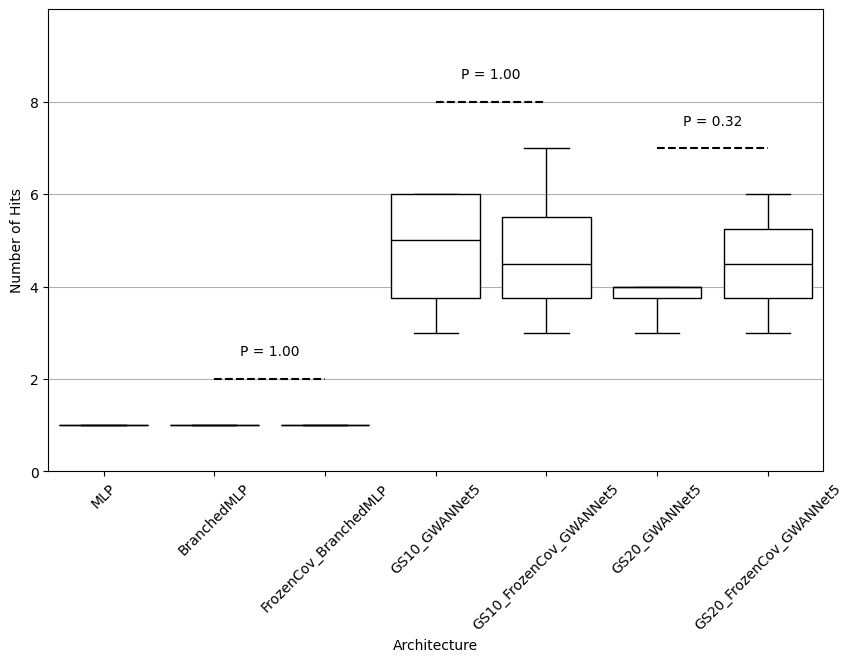

In [5]:
order = ['MLP', 'BranchedMLP', 'FrozenCov_BranchedMLP', 
        'GS10_GWANNet5', 'GS10_FrozenCov_GWANNet5', 
        'GS20_GWANNet5', 'GS20_FrozenCov_GWANNet5']
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=arch_df, x='Architecture', y='Number of Hits', 
            order=order,  whis=(0, 100),
            color='white', linecolor='black', ax=ax)
plt.draw()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_yticks(np.arange(0, 10, 2))
ax.set_yticklabels(np.arange(0, 10, 2))
ax.set_ylim((ax.get_ylim()[0], ax.get_ylim()[1]+2))
ax.grid(visible=True, axis='y')
# T-test between frozen and unfrozen covariates
i=1
for arch in ['BranchedMLP', 'GS10_GWANNet5', 'GS20_GWANNet5']:
    arch1 = arch
    if 'GWANNet5' in arch:
        arch2 = arch.replace('GWANNet5', 'FrozenCov_GWANNet5')
    else:
        arch2 = f'FrozenCov_{arch}'
    hits1 = arch_df[arch_df['Architecture'] == arch1]['Number of Hits']
    hits2 = arch_df[arch_df['Architecture'] == arch2]['Number of Hits']
    t_stat, p_val = stats.ttest_ind(hits1, hits2)
    
    if np.isnan(p_val):
        p_val = 1

    ax.axhline(max(hits1.max(), hits2.max())+1, 
                xmin=(i+0.5)/(ax.get_xlim()[1] - ax.get_xlim()[0]), 
                xmax=(i+1.5)/(ax.get_xlim()[1] - ax.get_xlim()[0]), 
                color='black', linestyle='--',)
    ax.text(i+0.5, max(hits1.max(), hits2.max())+1.5, f'P = {p_val:.2f}', ha='center')
    i += 2

os.chdir('/home/upamanyu/GWANN/Code_AD/results_Sens8_v4')
os.makedirs('architecture_plots', exist_ok=True)
plt.savefig('architecture_plots/number_of_hits.png', dpi=300, bbox_inches='tight')
plt.savefig('architecture_plots/number_of_hits.svg', bbox_inches='tight')

# GWAS Catalog and AGORA plot

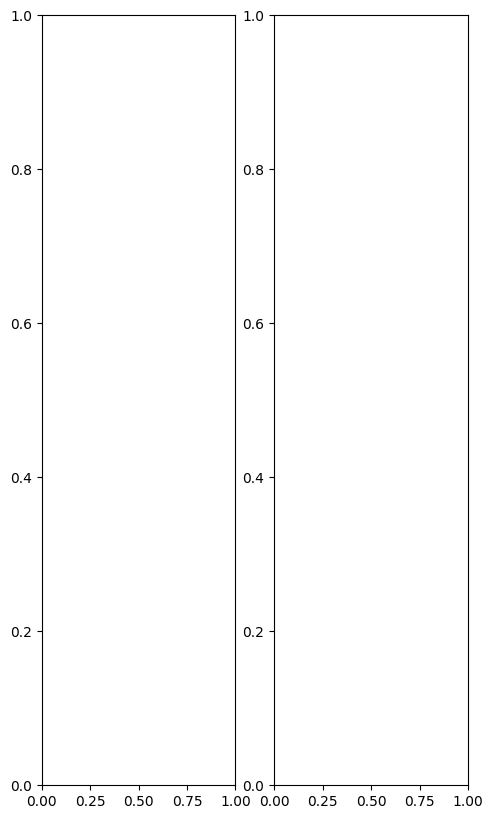

In [24]:
os.chdir('/home/upamanyu/GWANN/Code_AD/results_Sens8_v4')
fig, axes = plt.subplots(1, 2, figsize=(5.5, 10))
axes = axes.flatten()

## GWAS Catalog

In [25]:
ax = axes[0]
overlap_path = 'enrichments/gwas_catalog_overlap_1e-25.csv'
gwas_AD_overlap = pd.read_csv(overlap_path, index_col=0)

# Heatmap 
gwas_AD_overlap[gwas_AD_overlap == 0] = np.nan
gwas_AD_overlap.sort_values(['Alzheimer\'s disease', 'Neurofibrillary tangles or \ntau protein meausurement'], 
                            ascending=False, inplace=True)
sns.heatmap(data=gwas_AD_overlap, ax=ax, yticklabels=True, cmap='Reds', 
            annot=True, cbar=False)
for t in ax.texts:
    t.set_fontsize(16)
ax.set_ylabel('Genes', fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=16)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
# cbar = ax.collections[0].colorbar
# cbar.set_label("Number of GWAS", fontsize=16)
# cbar.ax.tick_params(labelsize=16)

with open('enrichments/gwas_catalog_overlap_ytick_order.txt', 'w') as f:
    f.write('\n'.join([l.get_text() for l in ax.get_yticklabels()]))


## AGORA

In [26]:
ax = axes[1]

agora_res_path = f'enrichments/AGORA.csv'
agora_df = pd.read_csv(agora_res_path)

# Agora heatmap
agora_df = agora_df[['is_any_rna_changed_in_ad_brain', 
                        'is_any_protein_changed_in_ad_brain', 'is_eqtl', 
                        'BRAAK', 'CERAD', 'COGDX', 'hgnc_symbol']]
agora_df['COGDX'] = agora_df['COGDX'] < 0.05
agora_df['BRAAK'] = agora_df['BRAAK'] < 0.05
agora_df['CERAD'] = agora_df['CERAD'] < 0.05
agora_df.rename(columns={'is_any_rna_changed_in_ad_brain':'RNA change \nin AD brain',
                            'is_any_protein_changed_in_ad_brain':'Protein change \nin AD brain',
                            'is_eqtl':'Brain eQTL',
                            'hgnc_symbol': 'Gene'}, inplace=True)
agora_df = agora_df.filter(['Gene', 'RNA change \nin AD brain', 
                            'Protein change \nin AD brain',
                            'Brain eQTL'])
agora_df.set_index('Gene', inplace=True)
agora_df = agora_df.apply(lambda x:x.astype(float), axis=0)

# order according to gwas catalog overlap plot order
with open('enrichments/gwas_catalog_overlap_ytick_order.txt', 'r') as f:
    gene_order = f.read().split('\n')
agora_df = agora_df.loc[gene_order]

cmap = copy.copy(plt.cm.get_cmap('Reds'))
cmap.set_under(color='white')
sns.heatmap(data=agora_df, cmap=cmap, cbar=False, xticklabels=True, 
            linewidths=0, ax=ax, vmin=0.1, vmax=1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=16)
ax.set_yticklabels([])
ax.yaxis.set_tick_params(length=10)
ax.set_ylabel('')
ax.set_xlabel('')

Text(0.5, 64.5222222222222, '')

In [27]:
fig.tight_layout()
fig.subplots_adjust(wspace=0.4)
fig.savefig(f'enrichments/GWAS_Cat_AGORA.svg')
fig.savefig(f'enrichments/GWAS_Cat_AGORA.png', dpi=300)

# Supplementary tables

In [2]:
os.chdir('/home/upamanyu/GWANN/Code_AD/results_Sens8_v4')

## Neuro disorders excluded from controls

In [7]:
neuro_df = pd.read_excel('enrichments/Neuro_disorders.xlsx')
neuro_df.to_excel('Supplementary_tables.xlsx', sheet_name="ST 6", index=False)

## TargetDB

In [8]:
target_df = pd.read_excel('enrichments/hits_targetDB.xlsx', header=1)
with pd.ExcelWriter('Supplementary_tables.xlsx', mode='a', engine='openpyxl',
                    if_sheet_exists='replace') as writer:
    target_df.to_excel(writer, sheet_name="ST 5", index=False)

## STRING EFO Enrichment

In [9]:
efo_df = pd.read_csv('enrichments/STRING_EFO_enrichment.csv')
with pd.ExcelWriter('Supplementary_tables.xlsx', mode='a', engine='openpyxl',
                    if_sheet_exists='replace') as writer:
    efo_df.to_excel(writer, sheet_name="ST 4", index=False)

## DisGEeNET Results

In [10]:
disgenet_df = pd.read_csv('enrichments/disgenet_enrichment.tsv', sep='\t')
with pd.ExcelWriter('Supplementary_tables.xlsx', mode='a', engine='openpyxl',
                    if_sheet_exists='replace') as writer:
    disgenet_df.to_excel(writer, sheet_name="ST 3", index=False)

## GSEA Results

In [11]:
gene_sets = ['Reactome', 'KEGG_Legacy', 'Wiki', 'GO']
gsea_df = []
for gene_set in gene_sets:
    fgsea_res = pd.read_csv(f'enrichments/fGSEA_{gene_set}.csv')
    fgsea_res['pathway_set'] = gene_set
    fgsea_res = fgsea_res[['pathway_set',] + fgsea_res.columns[:-1].tolist()]
    gsea_df.append(fgsea_res)
gsea_df = pd.concat(gsea_df)
with pd.ExcelWriter('Supplementary_tables.xlsx', mode='a', engine='openpyxl',
                    if_sheet_exists='replace') as writer:
    gsea_df.to_excel(writer, sheet_name="ST 2", index=False) 

## Summary stats

### White British Population

In [12]:
agg_df = pd.read_csv('results_Sens8_combined.csv')
agg_df = agg_df[['Gene', 'Seed', 'Loss']]
agg_df['Seed'] = agg_df['Seed'].apply(lambda x: f'NLL_{x}')
agg_df.head()

,Gene,Seed,Loss
0,A1BG-AS1_0,NLL_0,0.693240
1,A1BG-AS1_0,NLL_37,0.693247
2,A1BG-AS1_0,NLL_56,0.694238
3,A1BG-AS1_0,NLL_89,0.693272
4,A1BG-AS1_0,NLL_142,0.693744


In [13]:
agg_df = agg_df.pivot(index='Gene', columns='Seed', values='Loss')

In [14]:
res_df = pd.read_csv('summary_nsuperwins_1.csv')
res_df = res_df[['Gene', 'Chrom', 'stat_trial_A', 'p_stat_trial_A']]
res_df.rename(columns={'stat_trial_A': 'NLL', 'p_stat_trial_A': 'P-value'}, inplace=True)
res_df.set_index('Gene', inplace=True)

In [15]:
assert res_df.shape[0] == agg_df.shape[0]
summary_df = pd.merge(res_df, agg_df, left_index=True, right_index=True)
summary_df = summary_df.reset_index()
summary_df.sort_values(['Chrom', 'Gene'], inplace=True)
with pd.ExcelWriter('Supplementary_tables.xlsx', mode='a', engine='openpyxl',
                    if_sheet_exists='replace') as writer:
    summary_df.to_excel(writer, sheet_name="ST 1", index=False) 

### Asian and Black Populations

In [7]:
os.chdir('/home/upamanyu/GWANN/Code_AD/results_non_white')
pop = 'Asian'

agg_df = pd.read_csv(f'{pop}_results_top100.csv')
agg_df = agg_df[['Gene', 'Seed', 'Loss']]
agg_df['Seed'] = agg_df['Seed'].apply(lambda x: f'NLL_{x}')
agg_df.head()

,Gene,Seed,Loss
0,APOE_0,NLL_0,0.694409
1,BIN1_5,NLL_0,0.693266
2,NRG3_12,NLL_0,0.685724
3,LRRC7_9,NLL_0,0.693815
4,ROR1_16,NLL_0,0.697492


In [8]:
agg_df = agg_df.pivot(index='Gene', columns='Seed', values='Loss')

In [9]:
res_df = pd.read_csv(f'{pop}_summary_nsuperwins_1.csv')
res_df = res_df[['Gene', 'Chrom', 'stat_trial_A', 'p_stat_trial_A']]
res_df.rename(columns={'stat_trial_A': 'NLL', 'p_stat_trial_A': 'P-value'}, inplace=True)
res_df.set_index('Gene', inplace=True)

In [10]:
assert res_df.shape[0] == agg_df.shape[0]
summary_df = pd.merge(res_df, agg_df, left_index=True, right_index=True)
summary_df = summary_df.reset_index()
summary_df.sort_values(['Chrom', 'Gene'], inplace=True)
try:
    with pd.ExcelWriter('Supplementary_table_2.xlsx', mode='a', engine='openpyxl',
                        if_sheet_exists='replace') as writer:
        summary_df.to_excel(writer, sheet_name=f"ST 2 {pop}", index=False) 
except FileNotFoundError:
    with pd.ExcelWriter('Supplementary_table_2.xlsx', mode='w', engine='openpyxl') as writer:
        summary_df.to_excel(writer, sheet_name=f"ST 2 {pop}", index=False)